# CAC 40 Volatility Analysis Using Library

This notebook demonstrates how to use the volatility analysis library to analyze CAC 40 market volatility in relation to news sentiment.

In [1]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_lib import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance

In [2]:
# Configuration parameters
FETCH_DATA = False  # Set to True to fetch new news data
FROM = "2024-01-01"
TO = "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "CAC 40"

In [3]:
# CAC 40 search keywords
CAC_top_20 = [
    "CAC",  # CAC 40
    "Banque de France",  # Banque de France
    "Taux d'intérêt",  # Interest rates
    "Inflation",  # Inflation
    "PIB",  # GDP
    "Croissance économique",  # Economic growth
    "Crise économique",  # Economic crisis
    "Récession",  # Recession
    "Reprise économique",  # Economic recovery
    "Marché boursier",  # Stock market
    "Investissement",  # Investment
    "Actions",  # Equities
    "Obligations",  # Bonds
    "Dette publique",  # Public debt
    "Bourse de Paris",  # Paris Stock Exchange
    "Entreprises du CAC",  # CAC companies
    "Économie française",  # French economy
    "Chômage",  # Unemployment
    "Euro",  # Euro
    "LVMH",  # Major CAC company
]

In [4]:
# Fetch news data function
def fetch_cac_news_data():
    from pygooglenews import GoogleNews
    
    # Helper function to convert news to DataFrame
    def convert_to_dataframe(news):
        data = []
        for article in news['entries']:
            try:
                # Try the original format first
                date = datetime.strptime(article['published'], '%a, %d %b %Y %H:%M:%S %Z')
            except ValueError:
                # If that fails, use pd.to_datetime which is more flexible
                date = pd.to_datetime(article['published'])
                # Convert timezone-aware datetime to timezone-naive
                if date.tzinfo is not None:
                    date = date.replace(tzinfo=None)
            title = article['title']
            data.append({'date': date, 'title': title})
        return pd.DataFrame(data)
    
    # Create Google News instance
    gn = GoogleNews(lang="fr", country="FR")
    
    # Search for news with the keywords
    news = gn.search(
        query=" OR ".join(CAC_top_20),
        from_=FROM,
        to_=TO,
    )
    
    # Convert to DataFrame
    df = convert_to_dataframe(news)
    df['date'] = pd.to_datetime(df['date'])
    
    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    df.to_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", index=False)
    
    return df

In [5]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_cac_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_CAC.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 77 news articles


In [6]:
# Fetch CAC 40 market data using yfinance
cac40 = yfinance.Ticker("^FCHI")
cac40_data = cac40.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
cac40_data = cac40_data.reset_index()  # Convert index to column
cac40_data = cac40_data[["Date", "Close"]].copy()
cac40_data["Returns"] = cac40_data["Close"].pct_change()
cac40_data["Volatility"] = cac40_data["Returns"].rolling(window=21).std() * np.sqrt(252)
cac40_data = cac40_data.dropna().reset_index(drop=True)

print(f"Loaded {len(cac40_data)} days of CAC 40 market data")
cac40_data.head()

Loaded 331 days of CAC 40 market data


,Date,Close,Returns,Volatility
0,2024-01-31 00:00:00+01:00,7656.750000,-0.002699,0.134371
1,2024-02-01 00:00:00+01:00,7588.750000,-0.008881,0.125422
2,2024-02-02 00:00:00+01:00,7592.259766,0.000462,0.124554
3,2024-02-05 00:00:00+01:00,7589.959961,-0.000303,0.123355
4,2024-02-06 00:00:00+01:00,7638.970215,0.006457,0.124376


Calculating sentiment scores...


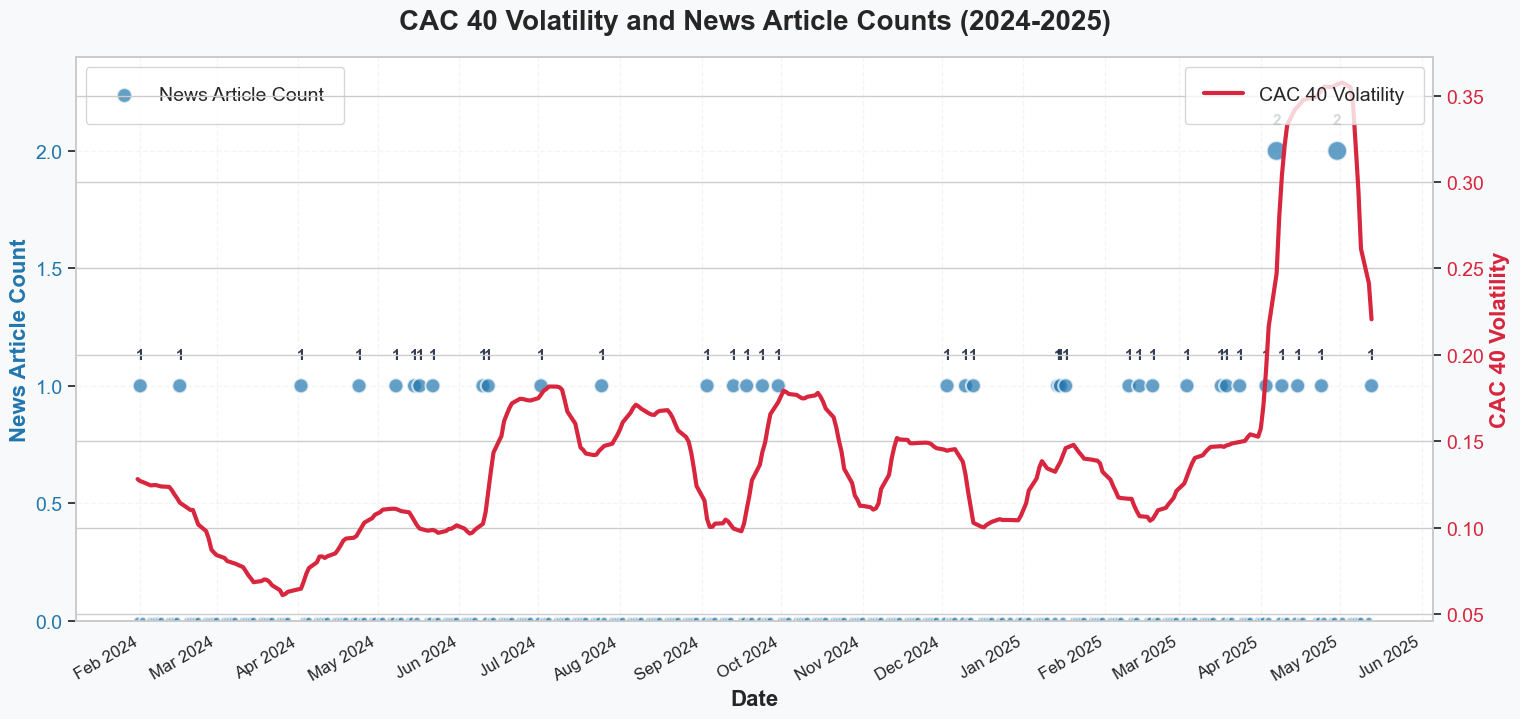

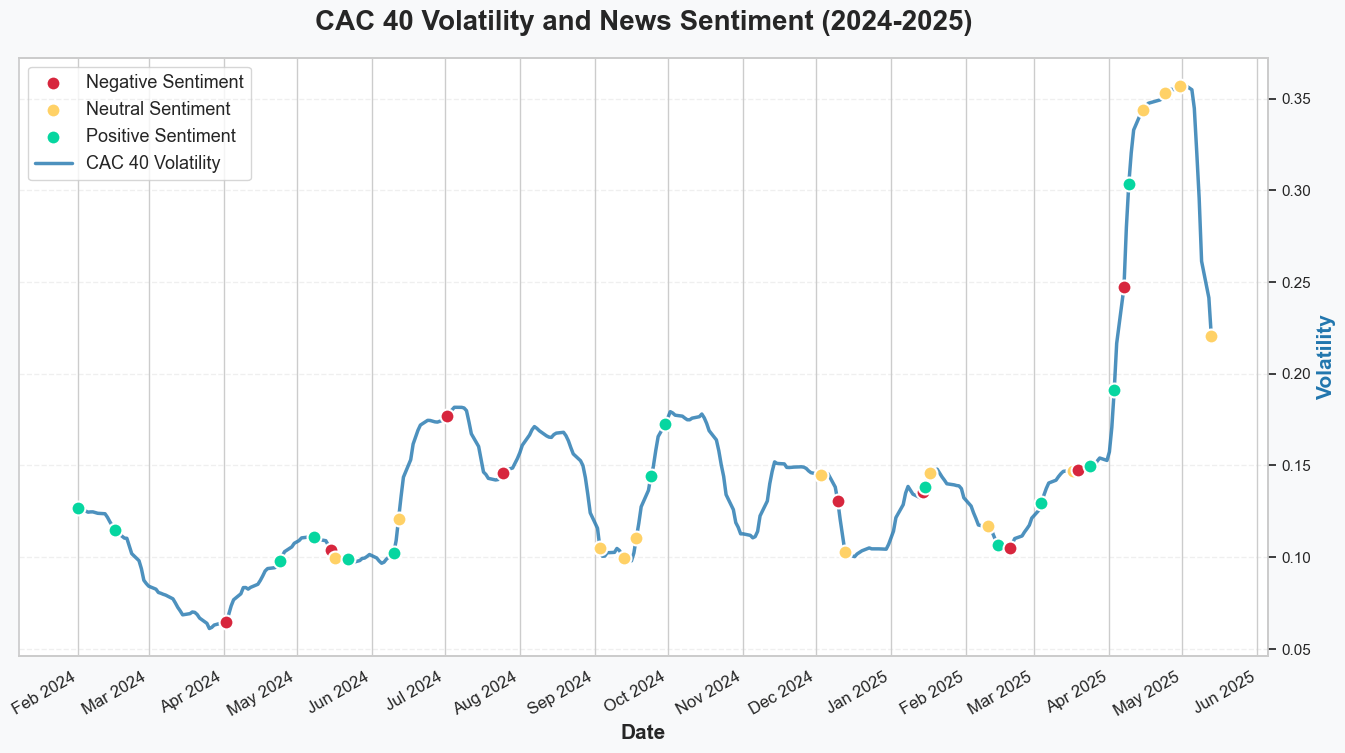

Splitting data at 2024-10-01...
Preparing data for LSTM model...
Training LSTM model with 50 epochs...
Epoch 1/50, Loss: 0.20198
Epoch 10/50, Loss: 0.03762
Epoch 20/50, Loss: 0.01260
Epoch 30/50, Loss: 0.00891
Epoch 40/50, Loss: 0.00308
Epoch 50/50, Loss: 0.00257
Evaluating LSTM model...
Model Performance Metrics:
MSE: 0.000815
RMSE: 0.028543
MAE: 0.014811
R² Score: 0.852715


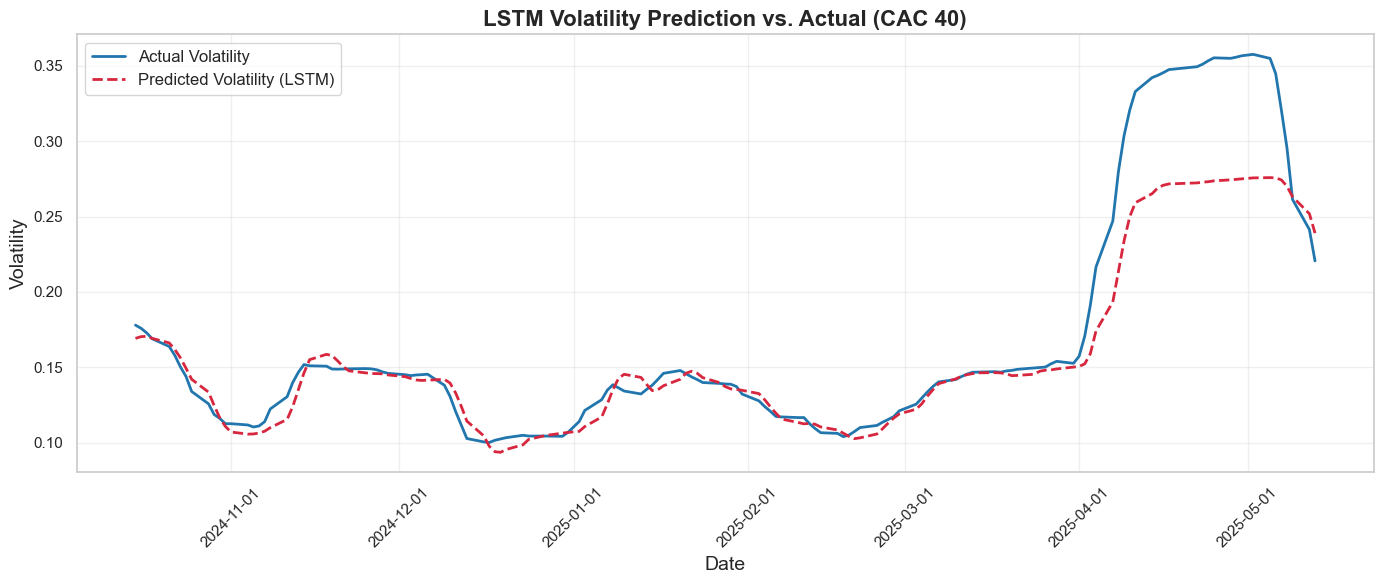

In [7]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=cac40_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    verbose=True
)

In [8]:
# Display model metrics
metrics = results['metrics']
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.6f}")

MSE: 0.000815
RMSE: 0.028543
MAE: 0.014811
R2: 0.852715


## Custom Analysis (Optional)

You can also use the library functions individually for custom analysis.

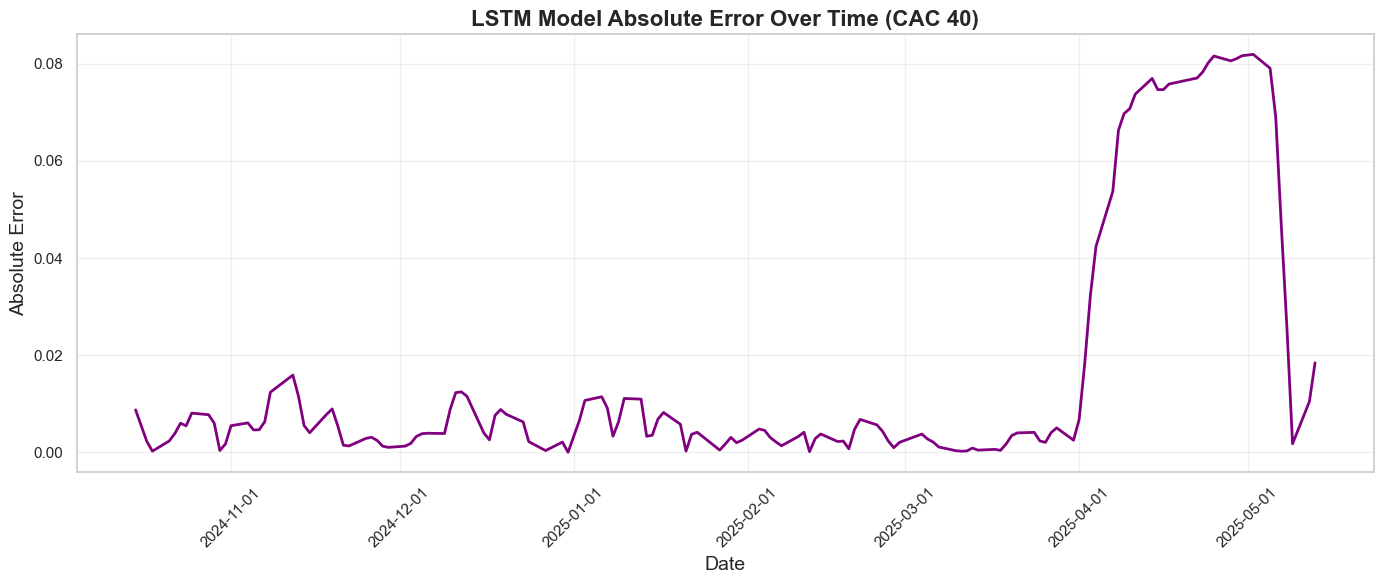

In [9]:
# Example: Creating a custom visualization of the model error over time
error = np.abs(results['y_actual'] - results['y_pred'])
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], error, color='purple', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (CAC 40)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../news/cac40_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

We've successfully analyzed CAC 40 volatility in relation to news sentiment using our reusable volatility analysis library.
The library provides functions for:

1. Sentiment analysis of financial news
2. Data preparation and LSTM model training
3. Volatility prediction and evaluation
4. Visualization of results

This approach can be applied to other market indices as well.